# Unsupervised Domain Adaptation

#### Loading in the required libraries

In [25]:
import torch
import torch.nn as nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
from torchinfo import summary
from tqdm import tqdm
import torch.optim as optim

#### Setting the device

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("The device is: ", device)

The device is:  cpu


## Loading in the OFFICE-31 dataset

In [12]:
data_path = 'OFFICE31'
amazon_path = os.path.join(data_path, 'amazon')
webcam_path = os.path.join(data_path, 'webcam')
dslr_path = os.path.join(data_path, 'dslr')

print('amazon_path:', amazon_path)
print('webcam_path:', webcam_path)
print('dslr_path:', dslr_path)

# Defining the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    # transforms.Normalize(  
    #     mean=[0.485, 0.456, 0.406],
    #     std=[0.229, 0.224, 0.225]
    # )
])

# Loading in the datasets for each of the domains
amazon_dataset = datasets.ImageFolder(amazon_path, transform=transform)
webcam_dataset = datasets.ImageFolder(webcam_path, transform=transform)
dslr_dataset = datasets.ImageFolder(dslr_path, transform=transform)

# Defining the dataloaders
batch_size = 32
amazon_dataloader = DataLoader(amazon_dataset, batch_size=batch_size, shuffle=True)
webcam_dataloader = DataLoader(webcam_dataset, batch_size=batch_size, shuffle=True)
dslr_dataloader = DataLoader(dslr_dataset, batch_size=batch_size, shuffle=True)

# Checking the size of the datasets
print('Amazon dataset size:', len(amazon_dataset))
print('Webcam dataset size:', len(webcam_dataset))
print('DSLR dataset size:', len(dslr_dataset))

amazon_path: OFFICE31/amazon
webcam_path: OFFICE31/webcam
dslr_path: OFFICE31/dslr
Amazon dataset size: 2817
Webcam dataset size: 795
DSLR dataset size: 498


#### Visualizing images from each domain

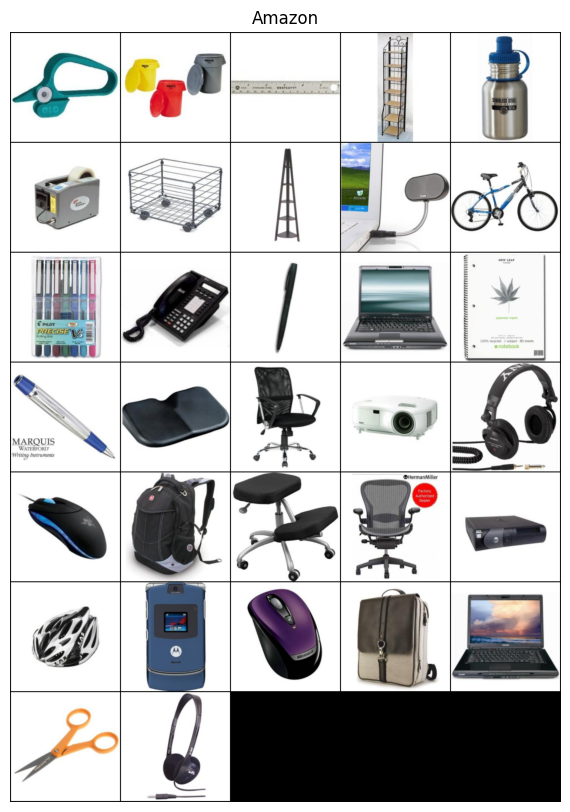

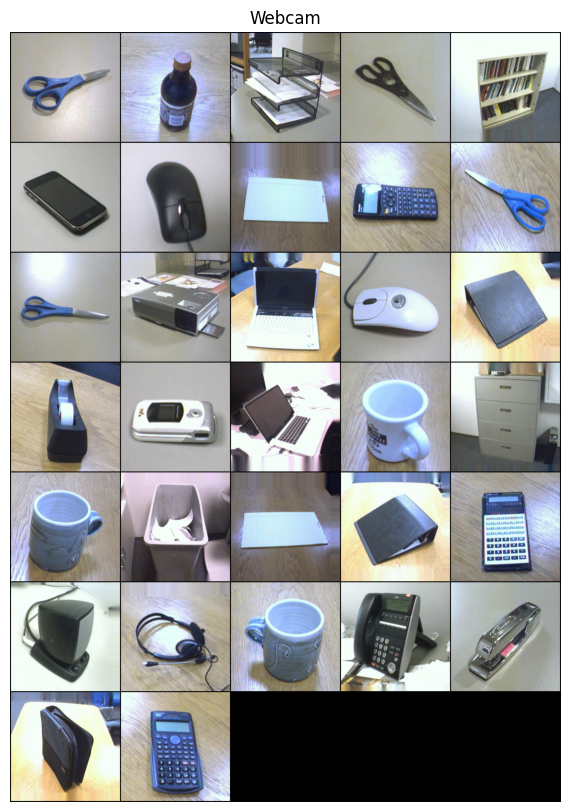

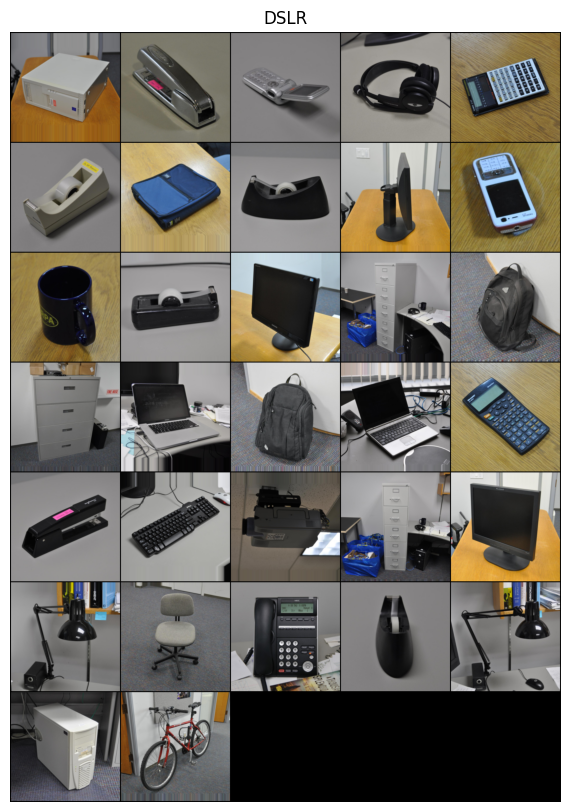

In [13]:
# Visualizing 5 images from each of the domains
def show_images(dataloader, domain_name):
    images, _ = next(iter(dataloader))
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(domain_name)
    plt.imshow(make_grid(images, nrow=5).permute(1, 2, 0))
    plt.show()

show_images(amazon_dataloader, 'Amazon')
show_images(webcam_dataloader, 'Webcam')
show_images(dslr_dataloader, 'DSLR')

## ResNet 50 Experiments

#### Loading in the ResNet 50 model and modifying the feature extractor backbone for Office 31 classification

In [20]:
# Loading in the resnet model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Checking the model summary
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

#### Modifying the feature extractor

In [23]:
num_classes = len(amazon_dataset.classes)
print("The number of classes is: ", num_classes)

# Modifying the final layer of the model to output the number of classes
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes)
# Sending the updated model to the device
model = model.to(device)

# Checking the updated model summary to verify the changes
summary(model, input_size=(1, 3, 224, 224))

The number of classes is:  31


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 31]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [26]:
# Single function for loading in the resnet model and modifying the final layer
def load_resnet_model(num_classes):
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes)
    model = model.to(device)
    return model

# Loading in the resnet model with the updated final layer
model = load_resnet_model(num_classes)

# Checking the model summary
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 31]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

#### Defining the function for training and testing

In [27]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function
def train_model(model, dataloader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

#### First experiment A -> W

In [28]:
model_A_to_W = load_resnet_model(num_classes)

# Training the model on the Amazon dataset
train_model(model_A_to_W, amazon_dataloader, optimizer, criterion, num_epochs=5)

# Evaluating the model on the Webcam dataset
evaluate_model(model_A_to_W, webcam_dataloader)

Epoch 1/5:   1%|          | 1/89 [00:19<28:46, 19.62s/it]


KeyboardInterrupt: 